In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
sns.set() # use seaborn plotting style

## Multinomial Naive Bayes Classifier

Code from https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a

In [29]:
train_data = pd.read_csv('final_data/train_balanced.csv')
valid_data = pd.read_csv('final_data/valid_balanced.csv')
test_data = pd.read_csv('final_data/test_balanced.csv')

In [6]:
# remove rows with missing values
train_data = train_data.dropna()
valid_data = valid_data.dropna()
test_data = test_data.dropna()

In [9]:
# value counts for each class
train_data['rating'].value_counts()

1    101812
0     43353
Name: rating, dtype: int64

In [17]:
# randomly remove some rows to get balanced classes
train_data = train_data.groupby('rating').apply(lambda x: x.sample(20000, replace=True)).reset_index(drop=True)
valid_data = valid_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)
test_data = test_data.groupby('rating').apply(lambda x: x.sample(2000, replace=True)).reset_index(drop=True)

# save to csv
train_data.to_csv('final_data/train_balanced.csv', index=False)
valid_data.to_csv('final_data/valid_balanced.csv', index=False)
test_data.to_csv('final_data/test_balanced.csv', index=False)

# value counts for each class
train_data['rating'].value_counts()

0    20000
1    20000
Name: rating, dtype: int64

In [16]:
# look at entire row of data
pd.set_option('display.max_colwidth', None)
train_data.head()

,review,rating
0,i wish i could rate what wast money horribl experi i would rather yeast infect rest life spend day go thi how still market i know women work compani use product havent gone superior said quotthi stuff sucksquot everi box well develop peopl work monistat set fire know feel like there noth quotmildquot itch burn it sever i cant hold stillal i want scratch i hate monistat,0
1,i took pill yearssinc i probabl never side effect issu happi it kept healthi weight even lost some help skin but ultim didnt suppos to took like clockwork got pregnant,0
2,i start take medicin age year took made feel realli like depress made feel hungeri never ate medicin would end day shen would start bing food night time medicin useless btw still adhd doesnt affect anyon myself,0
3,hate thi ive birth control one year now i gave chanc i bleed month two week i got i massiv depress last week i guess hormon chang then nonstop bleed cramp sometim light extrem annoy expens buy mani tampon i also gain pound last year i work dont eat it difficult tri get weight off dont use thi your doctor say great wont worri take pill everi day dont itit trap,0
4,i love thought period everi month advertis it work great amp year light spot i start back then lighter period buy mani tampon nice i got pill month for financi reason decid go back it im month two th day bleed start spot got heavier day after amp minor clot i saw dark brown blood day bleed thought end final next daybam back bright red bleed again amp horribl cramp go it im mess emot it like pm go away period start i think it turn me time switch i cant afford all pad,0


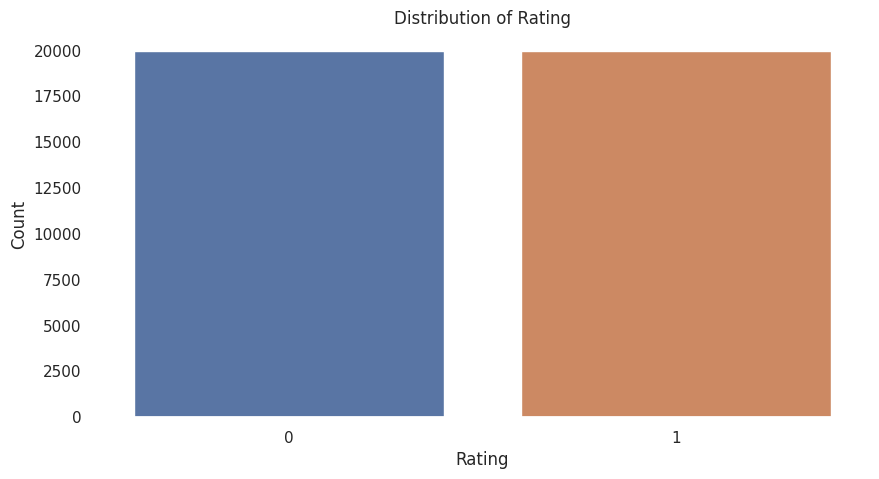

In [24]:
# look at distribution of rating
def look_at_rating(train_csv):
    # read train csv file
    df = pd.read_csv(train_csv)
    # set plot size
    plt.figure(figsize=(10, 5))
    # plot distribution of rating
    fig = sns.countplot(x='rating', data=df)
    fig.set_title('Distribution of Rating')
    fig.set_xlabel('Rating')
    fig.set_ylabel('Count')
    # remove background color
    fig.set_facecolor('white')
    # return plot object
    return fig
    
# look at distribution of rating
plt = look_at_rating('final_data/train_balanced.csv')

# save plot
plt.figure.savefig('plots/train_rating_distribution.png')

In [25]:
# percentage of positive reviews
train_data['rating'].value_counts(normalize=True)

0    0.5
1    0.5
Name: rating, dtype: float64

In [20]:
# number of total reviews
len(train_data)

40000

In [26]:
# look at the distribution of the labels for the test set
test_data['rating'].value_counts()

0    2000
1    2000
Name: rating, dtype: int64

In [30]:
# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
# Train the model using the training data
model.fit(train_data.review, train_data.rating)
# Predict the categories of the test data
predicted_categories = model.predict(test_data.review)

In [31]:
print(np.array(test_data.rating)[predicted_categories])

[0 0 0 ... 0 0 0]


In [32]:
# plot the confusion matrix
mat = confusion_matrix(test_data.rating, predicted_categories)
print(mat)

[[1449  551]
 [ 573 1427]]


In [33]:
# categories 
categories = train_data.rating.unique()
print(categories)

[0 1]


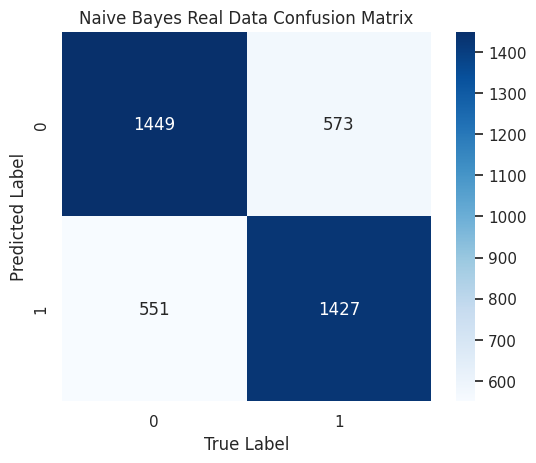

In [34]:
# plot and save the confusion matrix
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Naive Bayes Real Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/naive_bayes_real_confusion_matrix.png')

In [35]:
print("The accuracy is {}".format(accuracy_score(test_data.rating, predicted_categories)))

The accuracy is 0.719


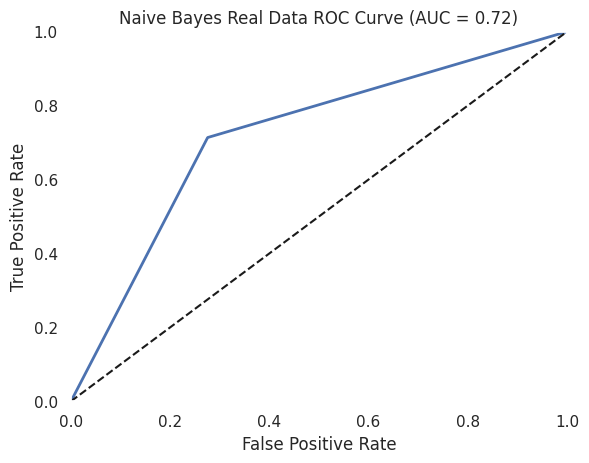

In [40]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_data.rating, predicted_categories)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # set background color to white
    plt.gca().set_facecolor('white')

# plot ROC curve and save
naive_bayes_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
auc_score = auc(fpr, tpr)
plt.title('Naive Bayes Real Data ROC Curve (AUC = %0.2f)' % auc_score)
plt.savefig('plots/naive_bayes_real_roc.png')

In [41]:
# get F1 score, precision, and recall
print(classification_report(test_data.rating, predicted_categories))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2000
           1       0.72      0.71      0.72      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



In [42]:
# print F1 score
print('F1 score: {}'.format(f1_score(test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(test_data.rating, predicted_categories)))

F1 score: 0.7174459527400703
Precision score: 0.7214357937310415
Recall score: 0.7135


## Generate Synthetic Data

In [45]:
# combine train and test data
combined_real_data = pd.concat([train_data, test_data], ignore_index=True)

In [46]:
# Total number of positive and negative reviews
combined_real_data['rating'].value_counts()

0    22000
1    22000
Name: rating, dtype: int64

In [47]:
# dictionary with terms and their percent frequencies from positive reviews
positive_terms = combined_real_data[combined_real_data.rating == 1].review.str.cat(sep=' ')
positive_terms = positive_terms.split()
positive_terms = pd.Series(positive_terms).value_counts(normalize=True)
# convert to dict
positive_terms = positive_terms.to_dict()

# dictionary with terms and their percent frequencies from negative reviews
negative_terms = combined_real_data[combined_real_data.rating == 0].review.str.cat(sep=' ')
negative_terms = negative_terms.split()
negative_terms = pd.Series(negative_terms).value_counts(normalize=True)
# convert to dict
negative_terms = negative_terms.to_dict()

In [48]:
# dictionary for review length and their percent frequencies from positive reviews
positive_review_length = combined_real_data[combined_real_data.rating == 1].review.str.len()
positive_review_length = positive_review_length.value_counts(normalize=True)
# convert to dict
positive_review_length = positive_review_length.to_dict()

# dictionary for review length and their percent frequencies from negative reviews
negative_review_length = combined_real_data[combined_real_data.rating == 0].review.str.len()
negative_review_length = negative_review_length.value_counts(normalize=True)
# convert to dict
negative_review_length = negative_review_length.to_dict()

In [49]:
# generate synthetic data based on category, review length, terms, n_reviews
def generate_synthetic_data(category, review_length, terms, n_reviews):
    # create empty list to store reviews
    reviews = []
    # loop through number of reviews
    for i in range(n_reviews):
        # get random review length
        length = np.random.choice(list(review_length.keys()), p=list(review_length.values()))
        # get random terms
        term = np.random.choice(list(terms.keys()), p=list(terms.values()), size=length)
        # join terms into review
        review = ' '.join(term)
        # add review to list
        reviews.append(review)
    # create dataframe
    df = pd.DataFrame({'review': reviews, 'rating': category})
    # return dataframe
    return df

In [54]:
# generate positive synthetic data
positive_synthetic_data = generate_synthetic_data(1, positive_review_length, positive_terms, 22000)
# save to csv
positive_synthetic_data.to_csv('final_data/positive_synthetic_data.csv', index=False)

In [ ]:
# generate negative synthetic data
negative_synthetic_data = generate_synthetic_data(0, negative_review_length, negative_terms, 22000)
# save to csv
negative_synthetic_data.to_csv('final_data/negative_synthetic_data.csv', index=False)

In [99]:
# combine positive and negative synthetic data
synthetic_data = pd.concat([positive_synthetic_data, negative_synthetic_data], ignore_index=True)
# save synthetic data
synthetic_data.to_csv('final_data/synthetic_data.csv', index=False)

145165

In [74]:
# load the synthetic data
synthetic_data = pd.read_csv("final_data/synthetic_data.csv")
# look at the distribution of the labels
synthetic_data['rating'].value_counts()
# percentage of positive reviews
synthetic_data['rating'].value_counts(normalize=True)

0    0.70071
1    0.29929
Name: rating, dtype: float64

In [ ]:
# split 

In [100]:
# Train new model using the synthetic data
syn_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
syn_model.fit(synthetic_data.review, synthetic_data.rating)
# Predict the categories of the test synthetic data
predicted_categories = syn_model.predict(synthetic_test_data.review)

[[15897    78]
 [31074  6715]]


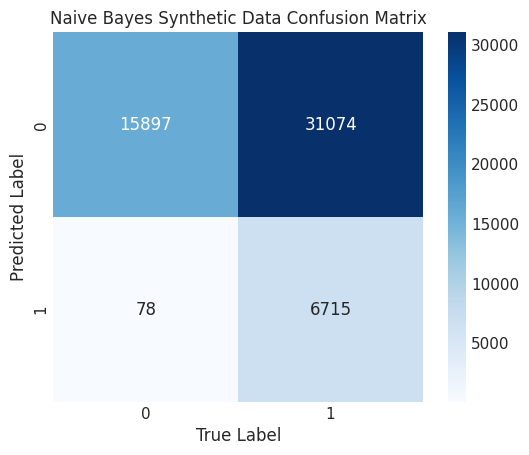

In [101]:
# plot and save the confusion matrix for synthetic data
mat = confusion_matrix(synthetic_test_data.rating, predicted_categories)
print(mat)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=categories, yticklabels=categories, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Naive Bayes Synthetic Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/naive_bayes_synthetic_confusion_matrix.png')

In [102]:
# print the accuracy for the synthetic data
print("The accuracy is {}".format(accuracy_score(synthetic_test_data.rating, predicted_categories)))

The accuracy is 0.4205788259802098


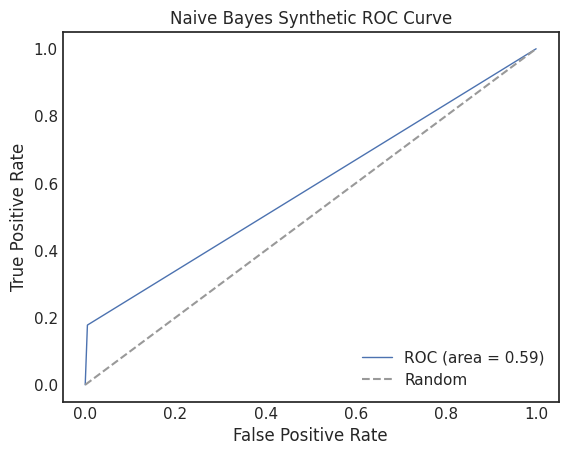

<Figure size 640x480 with 0 Axes>

In [86]:
# get ROC curve
fpr, tpr, thresholds = roc_curve(synthetic_test_data.rating, predicted_categories)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# title
plt.title('Naive Bayes Synthetic ROC Curve')
plt.legend(loc="lower right")
# set background color to white
ax = plt.gca()
ax.set_facecolor('white')
plt.show()
# save the ROC curve
plt.savefig("naive_bayes_synthetic_ROC.png")

In [87]:
# print F1 score
print('F1 score: {}'.format(f1_score(test_data.rating, predicted_categories)))

# print precision
print('Precision score: {}'.format(precision_score(test_data.rating, predicted_categories)))

# print recall
print('Recall score: {}'.format(recall_score(test_data.rating, predicted_categories)))

F1 score: 0.21461104847801576
Precision score: 0.7005741204180774
Recall score: 0.12671406129350055


In [ ]:
# for nerual network a lot lower 
# generated sentences don't make sense

: 